# **Delivery Dron Analysis**

# **Описание проекта**
Необходимо проанализировать данные о продажах иностранной интернет компании “Delivery Dron”, занимающейся продажей дронов доставщиков и работающей в четырех регионах c мая 2019 года.
# **Задачи**

*   сделать отчет о вложенных средствах
*   построить планы на следующий год
*   выяснить  в какой регион и какой рекламный канал инвестировать больше денег на привлечение клиентов в 2020 году





# **Описание данных**
Файл ecom_yl.csv содержит данные о визитах и покупках пользователей сайта интернет магазина “Delivery Dron”. Каждая строка представляет визит пользователя. Данные отсортированы по Session Date.

 Столбцы набора данных:

 0: User Id - id пользователя

 1: Region - регион визита

 2: Device - устройство, с которого производится вход на сайт

 3: Channel - рекламный канал перехода на сайт

 4: Session Start - время начала пользовательской сессии (входа на сайт)

 5: Session End - время окончания пользовательской сессии (уход с сайта)

 6: SessionDurationSec - длительность сессии в секундах

 7: Session Date - дата визита

 8: Month - месяц визита

 9: Day - день дня недели визита

 10: Hour of day - час (от 0 до 24) визита

 11: Order Dt - дата покупки

 12: Revenue - сумма покупки

 13: Payment Type - тип оплаты

 14: Promo code - использование промокода на скидку 10% (есть-1, нет-0).


# Шаг 0: Подготовка

## 0.1: Импорт библиотек

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import warnings

## 0.2: Константы и настройки

In [86]:
warnings.filterwarnings('ignore')

## 0.3: Загрузка данных

In [87]:
df = pd.read_csv("ecom_yl.csv", sep=",")
df.head()

,User Id,Region,Device,Channel,Session Start,Session End,SessionDurationSec,Session Date,Month,Day,Hour of day,Order Dt,Revenue,Payment Type,Promo code
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN


## 0.4: Пользовательские функции

In [88]:
def get_ohe(data: pd.DataFrame, categories: list):
  '''
  Функция, которая переводит номинальные шкалы в бинарные методом OneHotEncoder.
  '''
  ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
  ohe.fit(data[categories])

  temp_df = pd.DataFrame(data=ohe.transform(data[categories]), columns=ohe.get_feature_names_out())
  data = pd.concat([data.reset_index(drop=True), temp_df], axis=1)
  data = data.drop(columns=categories, axis=1)
  return data

## **Шаг 1: Исследовательский анализ данных и предобработка**

In [89]:
df.columns = df.columns.str.lower().str.replace(" ", "_")  #PEP8
df.info()
df.isnull().sum()
#df.fillna(0, inplace=True)
#df.drop_duplicates(inplace=True)
#доработать United States и Unjted States

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             1012 non-null   int64  
 1   region              999 non-null    object 
 2   device              999 non-null    object 
 3   channel             999 non-null    object 
 4   session_start       1012 non-null   object 
 5   session_end         1012 non-null   object 
 6   sessiondurationsec  1012 non-null   float64
 7   session_date        1012 non-null   object 
 8   month               1012 non-null   int64  
 9   day                 1012 non-null   int64  
 10  hour_of_day         1012 non-null   int64  
 11  order_dt            285 non-null    object 
 12  revenue             285 non-null    float64
 13  payment_type        285 non-null    object 
 14  promo_code          285 non-null    float64
dtypes: float64(3), int64(4), object(8)
memory usage: 118.7+

In [84]:
#перевести тип данных столбцов с датой и временем в соответствующий формат
df['session_start'] = pd.to_datetime(df['session_start'])
df['session_end'] = pd.to_datetime(df['session_end'])
df['session_date'] = pd.to_datetime(df['session_date'])
df['order_dt'] = pd.to_datetime(df['order_dt'])

In [90]:
 #добавить столбец итоговой суммой покупки с учетом применения промокода на скидку 10%
df['revenue_with_discount'] = df['revenue'] * (1 - df['promo_code'] * 0.1)
df.head()

,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,revenue_with_discount
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,0,0.0,0,0.0,0.0
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,0,0.0,0,0.0,0.0
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,0,0.0,0,0.0,0.0
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,0,0.0,0,0.0,0.0


In [91]:
start_date = df['session_date'].min() #починить
end_date = df['session_date'].max()

In [94]:
df = df[(df['sessiondurationsec'] > 0) & (df['revenue'] >= 0)]

In [92]:
#добавить столбец с указанием времени суток везита
def part_of_day(hour):
    if 6 <= hour < 10:
        return 'morning'
    elif 10 <= hour < 17:
        return 'day'
    elif 17 <= hour < 22:
        return 'evening'
    return 'night'


df['time_of_day'] = df['hour_of_day'].apply(part_of_day)
df.head(5)

,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,revenue_with_discount,time_of_day
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,night
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,0,0.0,0,0.0,0.0,morning
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,0,0.0,0,0.0,0.0,night
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,0,0.0,0,0.0,0.0,evening
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,0,0.0,0,0.0,0.0,day


In [96]:
#столбец “payer” с информацией о том, является ли пользователь платящим или нет
df['payer'] = df['revenue'].apply(lambda x: 1 if x > 0 else 0)
df.head()

,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,revenue_with_discount,time_of_day,payer
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,night,1
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,0,0.0,0,0.0,0.0,morning,0
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,0,0.0,0,0.0,0.0,night,0
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,0,0.0,0,0.0,0.0,evening,0
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,0,0.0,0,0.0,0.0,day,0


# **Шаг 2: Аналитический и графический анализ данных**

### 2.1) Доля продаж по регионам

In [104]:
sales_region = df.groupby('region')['revenue'].sum()
total_sales = df['revenue'].sum()
sales_region_perc = (sales_region / total_sales) * 100
print(sales_region_perc)

region
0                 1.807746
France            8.471654
Franсe            6.044089
Frаnce            2.220975
Frаncе            0.000000
Germany           5.939839
UK               13.585135
United States    48.191376
Unjted States    12.241299
UК                0.619819
germany           0.878068
Name: revenue, dtype: float64


### 2.2) Доля продаж по источникам

In [107]:
sales_сhannel = df.groupby('channel')['revenue'].sum()
sales_channel_perc = (sales_сhannel / total_sales) * 100
print(sales_channel_perc)

channel
0                       1.807746
email-рассылки          1.704477
organic                34.659709
контексная реклама      0.516499
контекстная реклама    11.053217
реклама у блогеров     17.976356
социальные сети        32.281997
Name: revenue, dtype: float64


### 2.3) Доля продаж по устройствам

In [110]:
sales_device = df.groupby('device')['revenue'].sum()
sales_device_perc = (sales_device / total_sales) * 100
print(sales_device_perc)

device
0           1.807746
Android    19.059154
Mac        21.900930
PC         24.329528
android     1.136318
iPhone     31.766324
Name: revenue, dtype: float64


### 2.4) Количество пользователей с разбивкой на платящих/не платящих по регионам

In [118]:
users_region = df.groupby(['region', 'payer']).size()
users_region = users_region.unstack()
print(users_region)

payer              0      1
region                     
0                5.0    7.0
France          39.0   13.0
Franсe           5.0    4.0
Frаnce          24.0    8.0
Frаncе          10.0    NaN
Germany         68.0   21.0
UK              81.0   30.0
United States  382.0  152.0
Unjted States  100.0   42.0
UК               2.0    2.0
germany         10.0    3.0


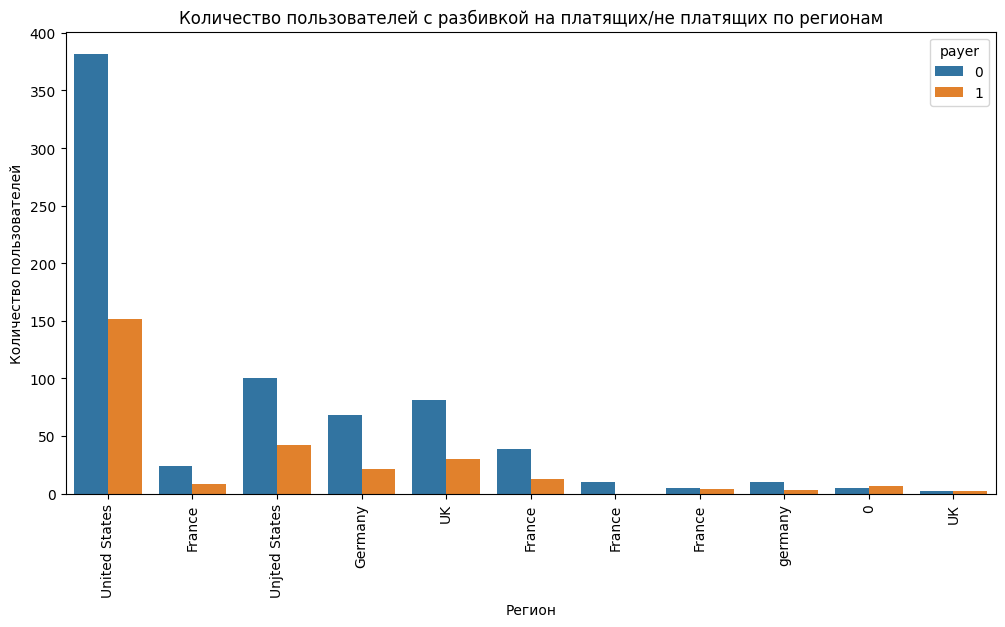

In [139]:
plt.figure(figsize=(12, 6))
sns.countplot(x=df['region'], hue=df['payer'])
plt.title('Количество пользователей с разбивкой на платящих/не платящих по регионам')
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=90)
plt.show()

### 2.5) Количество пользователей с разбивкой на платящих/не платящих по устройствам

In [122]:
users_device = df.groupby(['device', 'payer']).size()
users_device = users_device.unstack()
print(users_device)

payer      0   1
device          
0          5   7
Android  155  67
Mac      141  59
PC       155  51
android    9   4
iPhone   261  94


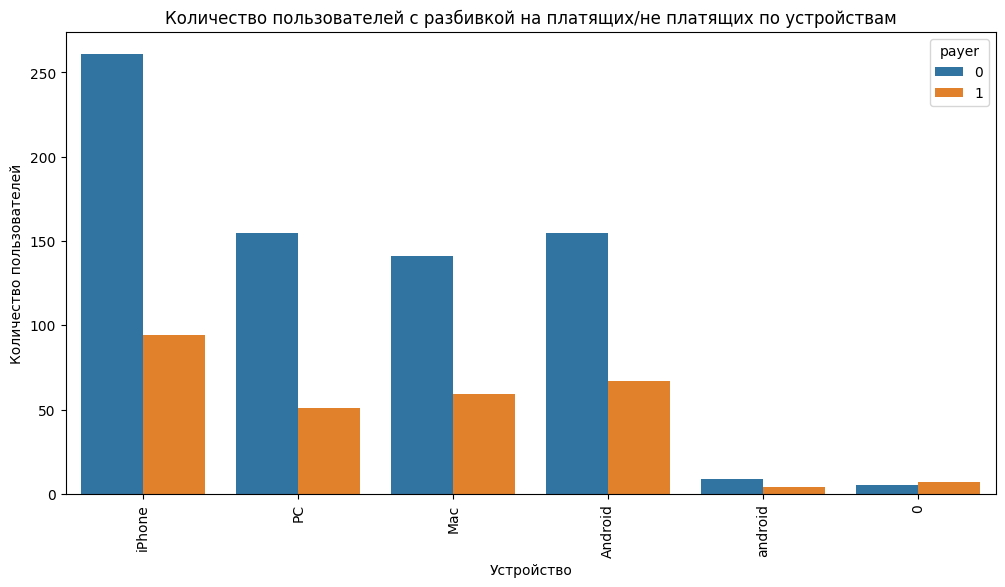

In [140]:
plt.figure(figsize=(12, 6))
sns.countplot(x=df['device'], hue=df['payer'])
plt.title('Количество пользователей с разбивкой на платящих/не платящих по устройствам')
plt.xlabel('Устройство')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=90)
plt.show()


### 2.6) Количество пользователей с разбивкой на платящих/не платящих по источникам

In [124]:
users_channel = df.groupby(['channel', 'payer']).size()
users_channel = users_channel.unstack()
print(users_channel)

payer                  0    1
channel                      
0                      5    7
email-рассылки        17    6
organic              258   87
контексная реклама     7    2
контекстная реклама  110   40
реклама у блогеров    71   29
социальные сети      258  111


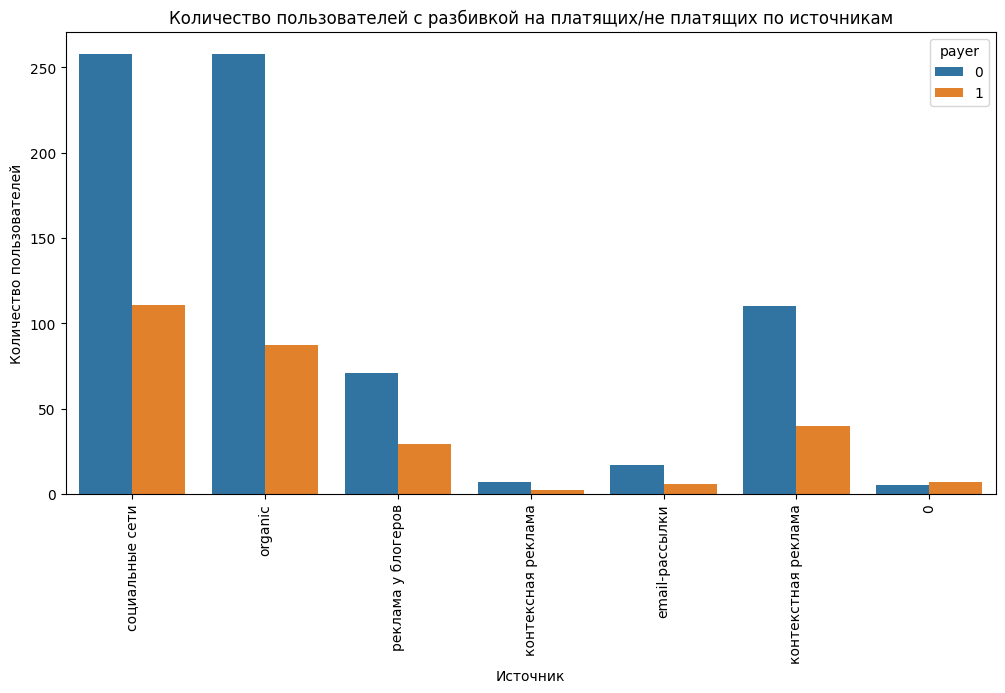

In [141]:
plt.figure(figsize=(12, 6))
sns.countplot(x=df['channel'], hue=df['payer'])
plt.title('Количество пользователей с разбивкой на платящих/не платящих по источникам')
plt.xlabel('Источник')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=90)
plt.show()

### 2.7) График сезонности в продажах по месяцам  

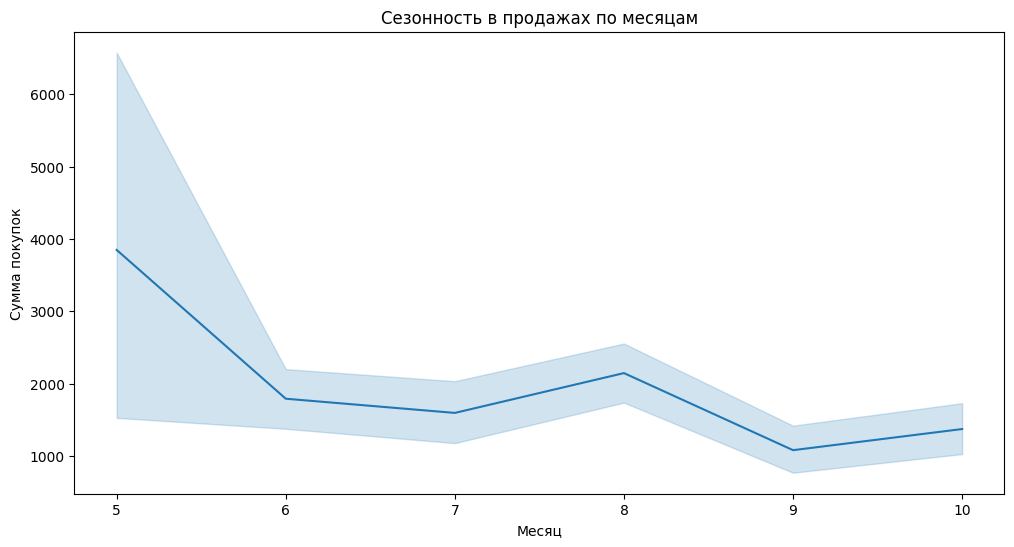

In [128]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='month', y='revenue')
plt.title('Сезонность в продажах по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма покупок')
plt.show()

### 2.8) График сезонности в продажах по дням недели

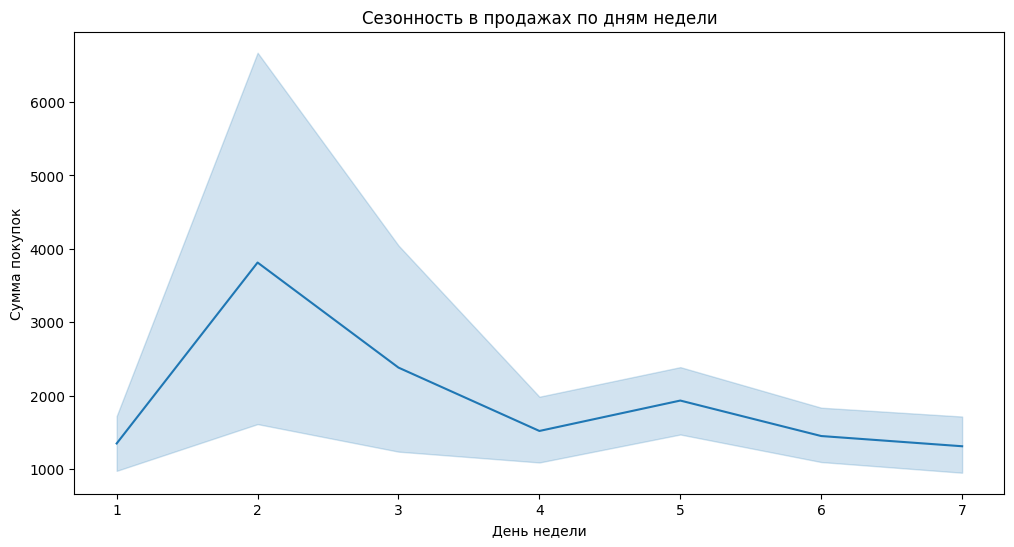

In [130]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='day', y='revenue')
plt.title('Сезонность в продажах по дням недели')
plt.xlabel('День недели')
plt.ylabel('Сумма покупок')
plt.show()

### 2.9) График сезонности в продажах по времени суток

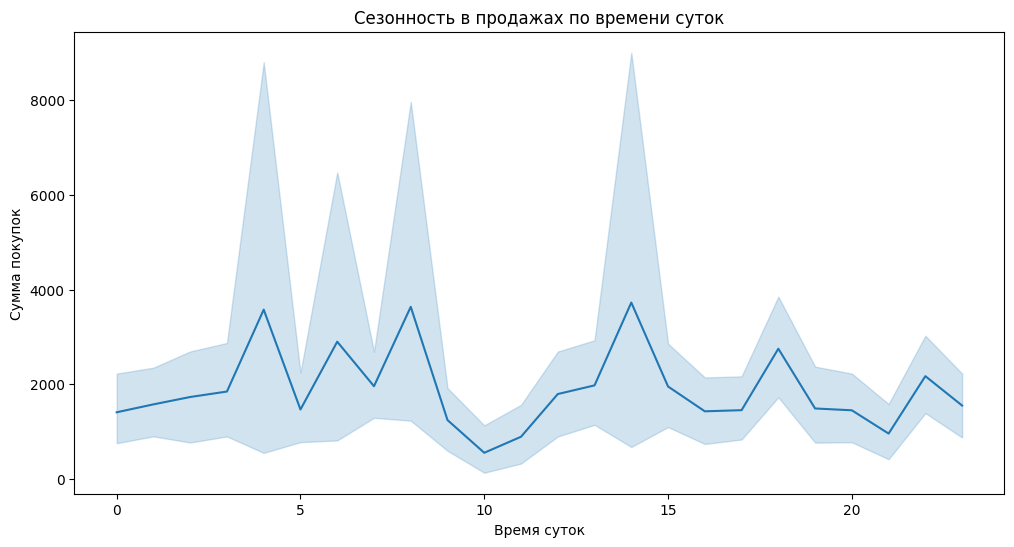

In [136]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour_of_day', y='revenue')
plt.title('Сезонность в продажах по времени суток')
plt.xlabel('Время суток')
plt.ylabel('Сумма покупок')
plt.show()

### 2.10) Диаграмма количества покупок по типу оплаты

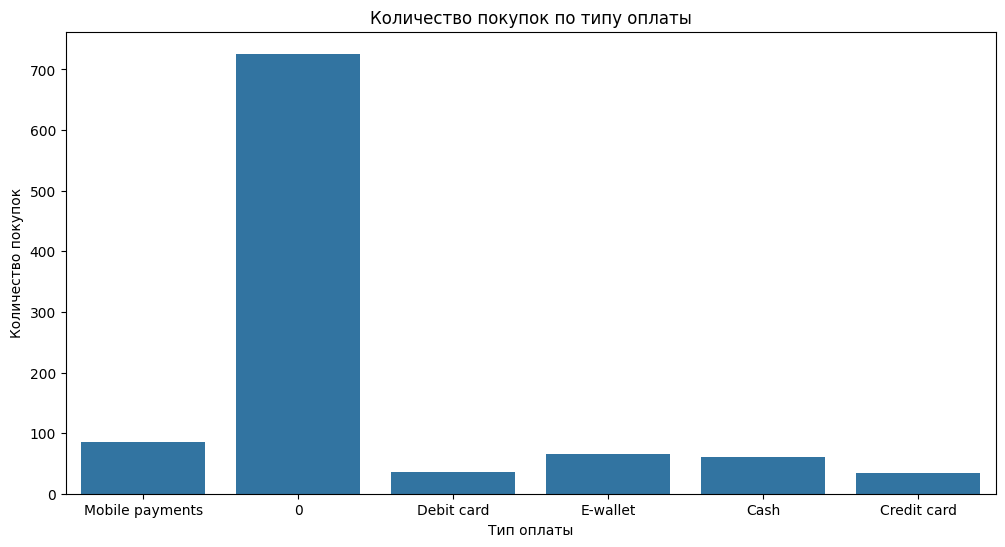

In [134]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='payment_type')
plt.title('Количество покупок по типу оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество покупок')
plt.show()

# **Шаг 3: Проведение расчетов**

### 3.1) Средний чек

In [143]:
av_check = df['revenue'].mean()
print(av_check)

1920.3630952380952


### 3.2) средняя продолжительность сессии по рекламным каналам